# Ribonanza - Attempt 3

A second approach to the [Stanford Ribonanza problem](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/) that builds off the first and second approaches.

Major differences:
- use of pytorch instead of tensorflow
- use of attention model architecture

Currently, the attention architecture scores 0.2049

## Todo

- improve model
- experiment with other types of attention
- use full transformer model (with decoder) (not just encoder)

## Setup

### Filesystem Setup

Your project directory should look like this:

- `(project directory)`
    - `ribonanza2.ipynb`
    - `train_data.csv`
    - `test_data.csv` (optional)

`train_data.csv` is the only file necessary for training, and it can be downloaded from the kaggle competition linked in the description.

`test_data.csv` is only necessary if you intend to make and submit predictions.

### Dependency Seetup

Need to install pip packages:
```sh
pip install torch numpy seaborn xformers arnie datasets
```
Need to install conda packages for eternafold:
```sh
conda install -c conda-forge "libgcc-ng>=12" "libstdcxx-ng>=12"
conda install -c bioconda eternafold
```

### Code Setup

In [1]:
# imports
import torch
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
from datasets import Dataset
import os

# for visualization
import seaborn

# typing hints
from typing import List
from collections.abc import Callable

# used for better attention mechanisms
import xformers.components.positional_embedding as embeddings
import xformers.ops as xops
import xformers.components.attention as attentions
import xformers.components.attention.utils as att_utils
import xformers.components as components

# used for bpps
from arnie.bpps import bpps

In [2]:
# constants

# according to kaggle, this is the maximum # of reactivites to be used
NUM_REACTIVITIES = 457

# there are 4 different bases (AUCG)
NUM_BASES = 4

In [3]:
DEVICE = "cuda"  # if no gpu available, use cpu

## Data Preprocessing

### Filter Data

In [4]:
def filter_data(out: str, key: str, value: str, file_name: str, force: bool):
    """
    Filters a file to only take datapoints
    whose values of `key` are `value`.

    Parameters:
        - out: str - the name of the file that will store the filtered datapoints
        - key: str - the name of the key to look at
        - value: str - the value that the key should have
        - file_name: str - the name of the file that contains all the datapoints.
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    if os.path.exists(out) and not force:
        print("File already exists, not doing any work")
        return

    count = 0

    # count how many lines we have in total
    with open(file_name) as file:
        line = file.readline()  # ignore the header
        line = (
            file.readline()
        )  # take the first line since we increment count in the loop
        while line != "":
            count += 1
            line = file.readline()

    # use that knowledge for a progress bar
    with open(file_name, "r") as file, open(out, "w") as outfile:
        # write the header
        header = file.readline()
        outfile.write(header)

        # get what index the SN_filter is
        SN_idx = header.split(",").index(key)

        # only take the approved filtered lines
        for _ in tqdm(range(count)):
            line = file.readline()
            temp = line.split(",")
            if temp[SN_idx] == value:
                outfile.write(line)


def filter_train_data(force: bool = False):
    """
    Filters the immense train_data.csv to only take datapoints
    whose SN_filter (Signal to Noise filter) is 1. In other words,
    we only take good reads. These filtered datapoints are then
    written to the file provided

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data("train_data_filtered.csv", "SN_filter", "1", "train_data.csv", force)


def filter_2A3(force: bool = False):
    """
    Only take the 2A3 points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_2a3.csv",
        "experiment_type",
        "2A3_MaP",
        "train_data_filtered.csv",
        force,
    )


def filter_DMS(force: bool = False):
    """
    Only take the DMS points

    Parameters:
        - force: bool - whether or not to force re-processing of the data (if False and `out` already exists, no work will be done)
    """
    filter_data(
        "train_data_dms.csv",
        "experiment_type",
        "DMS_MaP",
        "train_data_filtered.csv",
        force,
    )

In [5]:
# filter our data
filter_train_data()

File already exists, not doing any work


In [6]:
# take the 2a3 points
filter_2A3()

File already exists, not doing any work


In [7]:
# take the dms points
filter_DMS()

File already exists, not doing any work


### Convert Data to Inputs and Outputs

In [8]:
# encode inputs as
# A : 1
# U : 2
# C : 3
# G : 4
base_map = {
    "A": 1,
    "U": 2,
    "C": 3,
    "G": 4,
}

In [9]:
def process_data(row):
    """
    Convert a row containing all csv columns in the original dataset
    to a row containing only the columns:
    - inputs
    - outputs
    - bpp
    - output_masks
    - reactivity_error
    - bool_output_masks
    """
    # initialize arrays
    # note that we assume everything is masked until told otherwise
    inputs = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)
    bpp = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)
    output_masks = np.ones((NUM_REACTIVITIES,), dtype=np.bool_)
    reactivity_errors = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)
    reactivities = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)

    seq_len = len(row["sequence"])

    # encode the bases
    inputs[:seq_len] = np.array(
        list(map(lambda letter: base_map[letter], row["sequence"]))
    )

    # get the probability that any of those bases are paired
    bpp[:seq_len] = np.max(bpps(row["sequence"], package="eternafold"), axis=-1)

    # get the reactivities and their errors
    reactivities[:seq_len] = np.array(
        list(
            map(
                lambda seq_idx: np.float32(
                    row["reactivity_" + str(seq_idx + 1).rjust(4, "0")]
                ),
                range(seq_len),
            )
        )
    )
    reactivity_errors[:seq_len] = np.array(
        list(
            map(
                lambda seq_idx: np.float32(
                    row["reactivity_error_" + str(seq_idx + 1).rjust(4, "0")]
                ),
                range(seq_len),
            )
        )
    )

    # replace reactivity error nans with 0s (assume no error)
    reactivity_errors = np.where(np.isnan(reactivity_errors), 0.0, reactivity_errors)

    # get where all the reactivities are nan
    nan_locats = np.isnan(reactivities)

    # where it is nan, store True, else False
    output_masks[:seq_len] = nan_locats[:seq_len]

    # where it is not nan, store the reactivity and error, else 0
    reactivities[:seq_len] = np.where(
        nan_locats[:seq_len] == False, reactivities[:seq_len], 0.0
    )
    reactivity_errors[:seq_len] = np.where(
        nan_locats[:seq_len] == False, reactivity_errors[:seq_len], 0.0
    )

    # store the values
    row = {}
    row["inputs"] = inputs
    row["bpp"] = bpp
    row["outputs"] = np.clip(reactivities, 0, 1)
    row["output_masks"] = np.clip(
        np.where(output_masks, 0.0, 1.0) - np.abs(reactivity_errors), 0, 1
    )
    row["bool_output_masks"] = output_masks
    row["reactivity_errors"] = np.abs(reactivity_errors)

    return row


def process_data_test(row):
    """
    Almost the same as process_data, except it only takes inputs and bpp
    """
    # initialize arrays
    # note that we assume everything is masked until told otherwise
    inputs = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)
    bpp = np.zeros((NUM_REACTIVITIES,), dtype=np.float32)

    seq_len = len(row["sequence"])

    # encode the bases
    inputs[:seq_len] = np.array(
        list(map(lambda letter: base_map[letter], row["sequence"]))
    )

    # get the probability that any of those bases are paired
    bpp[:seq_len] = np.max(bpps(row["sequence"], package="eternafold"), axis=-1)

    row["inputs"] = inputs
    row["bpp"] = bpp
    return row

In [10]:
def preprocess_csv(
    out: str,
    file_name: str,
    n_proc: int = 12,
    map_fn: Callable = process_data,
    extra_cols_to_keep: List[str] = [],
):
    """
    Preprocess the csv and save the preprocessed data as a dataset
    that can be loaded via datasets.Dataset.load_from_file

    The dataset contains the following items:
        - bool_output_masks: Tensor(dtype=torch.bool) - the output masks.
            If True, then that item should NOT be used to calculate loss.
            If False, then that item should be used to calculate loss
        - reactivity_errors: Tensor(dtype=torch.float32) - the reactivity errors
        - output_masks: Tensor(dtype=torch.float32) - the elementwise weights to multiply the loss by to properly
            account for masked items and reactivity errors
        - inputs: tensor(dtype=torch.float32) - the input sequence, specifically of shape (None, NUM_REACTIVITIES)
        - bpp: tensor(dtype=torch.float32)
        - outputs: tensor(dtype=torch.float32) - the expected reactivities. Note that a simple MAE or MSE loss will not
            suffice for training models on this dataset. Please use the output_masks tensor as well.

    Parameters:
        - out: str - the name of the file to save the arrays to
        - file_name: str - the name of the input csv file
        - n_proc: int - the number of processes to use while processing data
        - map_fn: Callable - the function to apply to all dataset rows
        - extra_cols_to_keep: List[str] - the names of any extra columns to keep in the dataset
    """
    if os.path.exists(out):
        print(
            "File already exists, not doing any work.\n"
            + "To force re-preprocessing, delete the dataset directory and restart the kernel."
        )
        return

    names_to_keep = [
        "reactivity_errors",
        "bool_output_masks",
        "output_masks",
        "inputs",
        "outputs",
        "bpp",
    ] + extra_cols_to_keep

    # load dataset and map it to our preprocess function
    ds = Dataset.from_csv(file_name).map(map_fn, num_proc=n_proc)

    # drop excess columns and save to disk
    ds.remove_columns(
        list(filter(lambda c: c not in names_to_keep, ds.column_names))
    ).save_to_disk(out)

In [11]:
preprocess_csv("train_data_2a3_preprocessed", "train_data_2a3.csv")

File already exists, not doing any work.
To force re-preprocessing, delete the dataset directory and restart the kernel.


In [12]:
preprocess_csv("train_data_dms_preprocessed", "train_data_dms.csv")

File already exists, not doing any work.
To force re-preprocessing, delete the dataset directory and restart the kernel.


In [13]:
preprocess_csv(
    "test_data_preprocessed",
    "test_sequences.csv",
    map_fn=process_data_test,
    extra_cols_to_keep=["id_min", "id_max"],
)

File already exists, not doing any work.
To force re-preprocessing, delete the dataset directory and restart the kernel.


### Load the desired dataset

In [14]:
desired_dataset = "2a3"  # either "2a3" or "dms"

In [15]:
dataset = Dataset.load_from_disk(
    f"train_data_{desired_dataset}_preprocessed"
).with_format("torch")
dataset

Dataset({
    features: ['inputs', 'bpp', 'outputs', 'output_masks', 'bool_output_masks', 'reactivity_errors'],
    num_rows: 210992
})

In [16]:
columns = ["inputs", "outputs", "output_masks", "bpp"]
split = (
    dataset.train_test_split(test_size=0.1).with_format("torch").select_columns(columns)
)
train_dataset = split["train"]
val_dataset = split["test"]

print(
    "train set is len", len(train_dataset), "and val dataset is len", len(val_dataset)
)

train set is len 189892 and val dataset is len 21100


### Visualize

Now that we have the dataset preprocessed, we can visualize what the distribution looks like

In [17]:
visualize = True

In [18]:
def multiply(*args):
    """
    Gets the product of all arguments passed to it
    """
    prod = 1
    for item in args:
        prod *= item
    return prod

In [19]:
if visualize:
    # select all the reactivities that are valid (that shouldn't be masked)
    visualized_items = torch.masked_select(
        dataset["outputs"], dataset["bool_output_masks"] == False
    ).numpy()

    # sanity check that we didn't take all the items
    print(
        f"took {visualized_items.shape[0] / multiply(*dataset['outputs'].shape):.5f}% of the data"
    )

took 0.21671% of the data


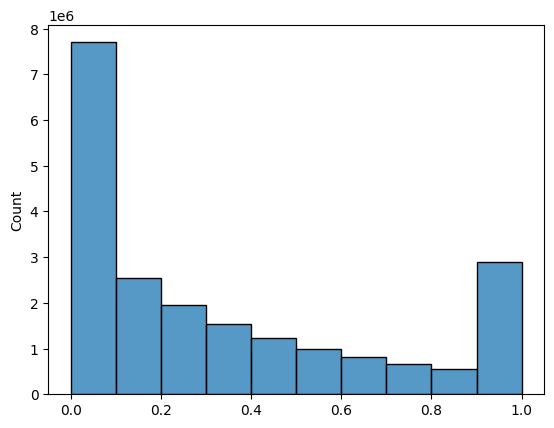

In [20]:
if visualize:
    seaborn.histplot(visualized_items, binwidth=0.1)
else:
    print("Not visualizing. Set `visualize` to `True` to visualize data")

## Model

To model our distribution, we have two models:
- an AttentionModel that uses attention layers
- a BaselineModel that we compare against that uses only a couple convolution layers and a Linear layer

In [21]:
class MemoryEfficientSelfAttention(torch.nn.Module):
    def __init__(
        self, latent_dim: int, n_heads: int, dropout: float, *args, **kwargs
    ) -> None:
        super(MemoryEfficientSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.latent_dim = latent_dim
        self.dropout = dropout

        assert latent_dim % n_heads == 0

    def forward(self, x: torch.Tensor, **kwargs):
        # B, Seq Len, embedding -> B, Seq Len, Heads, Embedding per head
        x = x.reshape(x.shape[0], x.shape[1], self.n_heads, x.shape[2] // self.n_heads)
        x = xops.memory_efficient_attention(x, x, x, p=self.dropout)
        x = x.reshape(x.shape[0], x.shape[1], -1)

        return x


class SDPAttention(torch.nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float,
        device: str,
        *args,
        **kwargs
    ) -> None:
        super(SDPAttention, self).__init__()
        self.mha = components.MultiHeadDispatch(
            latent_dim,
            num_heads=n_heads,
            attention=attentions.ScaledDotProduct(dropout=dropout),
        ).to(device)

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        return self.mha(x, att_mask=attention_mask)


class SlidingWindowAttention(torch.nn.Module):
    def __init__(
        self,
        latent_dim: int,
        n_heads: int,
        dropout: float,
        device: str,
        *args,
        **kwargs
    ) -> None:
        super(SlidingWindowAttention, self).__init__()
        self.mha = components.MultiHeadDispatch(
            latent_dim,
            n_heads,
            attentions.LocalAttention(
                dropout=dropout, window_size=kwargs["context_window"]
            ),
        ).to(device)

    def forward(self, x: torch.Tensor, **kwargs):
        return self.mha(x)

In [22]:
class CustomTransformerEncoderLayer(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        latent_dim: int,
        ff_dim: int,
        n_heads: int,
        dropout: float = 0.1,
        device: str = "cuda",
        *args,
        **kwargs
    ) -> None:
        super(CustomTransformerEncoderLayer, self).__init__()
        self.attention = attention_type(
            latent_dim=latent_dim,
            n_heads=n_heads,
            dropout=dropout,
            device=device,
            **kwargs
        )
        self.layer_norm = torch.nn.LayerNorm(latent_dim).to(device)

        self.ff1 = torch.nn.Linear(latent_dim, ff_dim).to(device)
        self.ff2 = torch.nn.Linear(ff_dim, latent_dim).to(device)
        self.gelu = torch.nn.GELU()

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        # MHA, add, norm
        x = self.layer_norm(self.attention(x, attention_mask=attention_mask) + x)

        # ff, add, norm
        x = self.layer_norm(self.gelu(self.ff2(self.gelu(self.ff1(x)))) + x)

        return x


class CustomTransformerEncoder(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        n_layers: int,
        latent_dim: int,
        ff_dim: int,
        n_heads: int,
        dropout: float = 0.1,
        device: str = "cuda",
        **kwargs
    ) -> None:
        super(CustomTransformerEncoder, self).__init__()
        for i in range(n_layers):
            self.add_module(
                str(i),
                CustomTransformerEncoderLayer(
                    attention_type=attention_type,
                    latent_dim=latent_dim,
                    ff_dim=ff_dim,
                    n_heads=n_heads,
                    dropout=dropout,
                    device=device,
                    **kwargs
                ),
            )

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor):
        for module in self._modules.values():
            x = module(x, attention_mask=attention_mask)
        return x


class AttentionModel(torch.nn.Module):
    def __init__(
        self,
        attention_type: torch.nn.Module,
        context_window: int = 31,
        latent_dim: int = 128,
        ff_dim: int = 1024,
        n_heads: int = 2,
        enc_layers: int = 1,
        device: str = "cuda",
    ) -> None:
        super(AttentionModel, self).__init__()

        # data
        self.n_heads = n_heads
        self.latent_dim = latent_dim

        # prepatory conv layers
        self.conv_layer = torch.nn.Conv1d(
            2, out_channels=latent_dim, kernel_size=context_window, padding="same"
        ).to(device)
        self.conv_layer_b = torch.nn.Conv1d(
            2, out_channels=latent_dim, kernel_size=context_window, padding="same"
        ).to(device)

        # positional embedding and encoder layers
        self.pos_embedding = embeddings.SinePositionalEmbedding(latent_dim).to(device)
        self.encoder_layers = CustomTransformerEncoder(
            latent_dim=latent_dim,
            ff_dim=ff_dim,
            n_heads=n_heads,
            device=device,
            attention_type=attention_type,
            n_layers=enc_layers,
            context_window=context_window,
        )

        # output head
        self.head = torch.nn.Linear(latent_dim, 1).to(device)
        self.final_result = torch.nn.Linear(NUM_REACTIVITIES, NUM_REACTIVITIES).to(
            device
        )

        # activations
        self.relu = torch.nn.ReLU()
        self.gelu = torch.nn.GELU()

    def forward(self, x: torch.Tensor):
        mask = att_utils.maybe_merge_masks(
            att_mask=None,
            key_padding_mask=(x != 0).any(dim=-1),
            batch_size=x.shape[0],
            num_heads=self.n_heads,
            src_len=x.shape[1],
        )
        x = x.reshape(x.shape[0], -1, x.shape[1])
        # print(x.shape)

        x = self.gelu(
            self.conv_layer(x)
            + torch.flip(self.conv_layer_b(torch.flip(x, dims=[2])), dims=[2])
        )
        # print(x.shape)

        x = x.permute((0, 2, 1)).contiguous()

        x = self.pos_embedding(x)
        x = self.encoder_layers(x, attention_mask=mask)

        x = self.relu(self.final_result(self.gelu(self.head(x).flatten(start_dim=1))))
        # print(x.shape)
        return x

In [23]:
class BaselineModel(torch.nn.Module):
    def __init__(self, context_window: int = 31, device: str = "cuda"):
        super(BaselineModel, self).__init__()
        self.preLayer = torch.nn.Linear(2, 2).to(device)
        self.conv_layer = torch.nn.Conv1d(2, 2, context_window, padding="same").to(
            device
        )
        self.conv_layer_b = torch.nn.Conv1d(2, 2, context_window, padding="same").to(
            device
        )
        self.ff = torch.nn.Linear(NUM_REACTIVITIES * 2, NUM_REACTIVITIES).to(device)
        self.gelu = torch.nn.GELU()
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.gelu(self.preLayer(x))
        x = x.reshape(x.shape[0], -1, x.shape[1])

        x = self.gelu(
            self.conv_layer(x)
            + torch.flip(self.conv_layer_b(torch.flip(x, dims=[2])), dims=[2])
        )

        return self.relu(self.ff(x.flatten(start_dim=1)))

In [24]:
model_dms_kwargs = dict(
    latent_dim=16, n_heads=2, enc_layers=1, ff_dim=512, attention_type=SDPAttention
)
model_2a3_kwargs = dict(
    latent_dim=16, n_heads=2, enc_layers=1, ff_dim=512, attention_type=SDPAttention
)

In [25]:
use_baseline = True

# select the model
if use_baseline:
    model = BaselineModel()
elif desired_dataset == "dms":
    model = AttentionModel(**model_dms_kwargs)
elif desired_dataset == "2a3":
    model = AttentionModel(**model_2a3_kwargs)

In [26]:
# load old weights if possible
if os.path.exists(f"{desired_dataset}_model"):
    try:
        model.load_state_dict( torch.load(f"{desired_dataset}_model"))
        print("loaded previous weights")
    except Exception as e:
        print("not loading previous weights because", e)
        pass

In [27]:
# make sure that calling the model works as expected
inp = torch.zeros((2, NUM_REACTIVITIES, 2))
inp[:, 0, :] = 1

model(inp.cuda()).cpu().detach()

tensor([[0.0000, 0.0000, 0.0000, 0.0623, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0352, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0762,
         0.0000, 0.2149, 0.1514, 0.1430, 0.2965, 0.3544, 0.1241, 0.1007, 0.1970,
         0.1964, 0.3502, 0.3582, 0.1733, 0.0899, 0.2445, 0.1897, 0.1143, 0.0987,
         0.0872, 0.0965, 0.0000, 0.0000, 0.0000, 0.0030, 0.0000, 0.1981, 0.0881,
         0.1302, 0.0469, 0.1013, 0.2789, 0.1499, 0.1239, 0.0213, 0.1044, 0.0307,
         0.1926, 0.1326, 0.0308, 0.2311, 0.0000, 0.0000, 0.0227, 0.0000, 0.0856,
         0.0000, 0.0320, 0.0659, 0.1245, 0.2019, 0.2541, 0.1233, 0.2132, 0.2556,
         0.1207, 0.2677, 0.2141, 0.2567, 0.4317, 0.2617, 0.1836, 0.1618, 0.1791,
         0.2635, 0.2979, 0.3243, 0.2830, 0.2639, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [28]:
print(model)

BaselineModel(
  (preLayer): Linear(in_features=2, out_features=2, bias=True)
  (conv_layer): Conv1d(2, 2, kernel_size=(31,), stride=(1,), padding=same)
  (conv_layer_b): Conv1d(2, 2, kernel_size=(31,), stride=(1,), padding=same)
  (ff): Linear(in_features=914, out_features=457, bias=True)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
)


In [29]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total params:", params)

Total params: 418413


In [30]:
# create optimizer
optimizer = torch.optim.AdamW(model.parameters(), 1e-3)

## Train

In [31]:
BATCH_SIZE = 1024
SHUFFLE = True

# create dataloaders
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# no point in shuffling validation set
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
def weightedL1(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    weights: torch.Tensor,
    l1=torch.nn.L1Loss(),
):
    """
    This is our custom loss function that takes into account sample weights
    """
    return (l1(y_pred, y_true) * weights).sum(dim=-1).mean()

In [33]:
def train_batch(
    m: torch.nn.Module, inps: torch.Tensor, outs: torch.Tensor, masks: torch.Tensor
):
    """
    Get the loss on a batch and perform the corresponding weight updates.
    Used for training purposes
    """
    optimizer.zero_grad()
    loss = weightedL1(m(inps), outs, masks)

    loss.backward()

    # calculate gradients
    optimizer.step()

    # return mae loss
    return loss


def noupdate_batch(
    m: torch.nn.Module, inps: torch.Tensor, outs: torch.Tensor, masks: torch.Tensor
):
    """
    Get the loss on a batch without performing any updates.
    Used for validation purposes
    """
    with torch.no_grad():
        loss = weightedL1(m(inps), outs, masks)

    # return mae loss
    return loss


def masked_train(
    m: torch.nn.Module,
    train_dataloader: data.DataLoader,
    val_dataloader: data.DataLoader,
    epochs: int = 1,
    device: str = DEVICE,
):
    """
    Train the given model.

    Arguments:
        - m: torch.nn.Module - the model to train.
        - train_dataloader: data.Dataloader - the dataloader that provides the batched training data
        - val_dataloader: data.Dataloader - the dataloader that provides the batched validation data
        - epochs: int - how many epochs to train for. Defaults to `1`.
        - device: str - the device to train on, defaults to `DEVICE`
    """
    m = m.to(device)

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}")
        epoch_mae = 0.0

        m = m.train()
        for batch, tdata in enumerate(train_dataloader):
            inps = torch.stack([tdata["inputs"], tdata["bpp"]], dim=-1)
            outs = tdata["outputs"]
            masks = tdata["output_masks"]

            inps = inps.to(device)
            outs = outs.to(device)
            masks = masks.to(device)

            mae_loss = train_batch(m, inps, outs, masks).detach().cpu()

            epoch_mae += mae_loss

            # log
            print(
                f"Batch {batch+1}/{len(train_dataloader)}\t- mae loss: {mae_loss:.5f}",
                end="\r",
            )

            # break  # used for sanity check
        epoch_mae /= batch + 1

        # do validation
        val_mae = 0.0
        m = m.eval()
        for batch, vdata in enumerate(val_dataloader):
            inps = torch.stack([vdata["inputs"], vdata["bpp"]], dim=-1)
            outs = vdata["outputs"]
            masks = vdata["output_masks"]

            inps = inps.to(device)
            outs = outs.to(device)
            masks = masks.to(device)
            mae_loss = noupdate_batch(m, inps, outs, masks)

            val_mae += mae_loss
        val_mae /= len(val_dataloader)

        print()
        print(f"Epoch MAE: {epoch_mae:.5f}\tVal MAE: {val_mae:.5f}")

In [34]:
# baseline gets ~ 3.64968 on dms w/ 10 epochs, ~ 4.64478 on 2a3 w/ 10 epochs
masked_train(
    model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, epochs=20
)

Epoch 1


Batch 186/186	- mae loss: 3.88938
Epoch MAE: 3.89894	Val MAE: 3.90925
Epoch 2
Batch 186/186	- mae loss: 3.89901
Epoch MAE: 3.88558	Val MAE: 3.89925
Epoch 3
Batch 186/186	- mae loss: 3.84362
Epoch MAE: 3.87768	Val MAE: 3.89741
Epoch 4
Batch 186/186	- mae loss: 3.85658
Epoch MAE: 3.87446	Val MAE: 3.89622
Epoch 5
Batch 186/186	- mae loss: 3.92030
Epoch MAE: 3.87154	Val MAE: 3.89395
Epoch 6
Batch 186/186	- mae loss: 3.83593
Epoch MAE: 3.86820	Val MAE: 3.89068
Epoch 7
Batch 186/186	- mae loss: 3.87538
Epoch MAE: 3.86560	Val MAE: 3.88949
Epoch 8
Batch 186/186	- mae loss: 3.86100
Epoch MAE: 3.86290	Val MAE: 3.88726
Epoch 9
Batch 186/186	- mae loss: 3.79003
Epoch MAE: 3.85874	Val MAE: 3.88503
Epoch 10
Batch 186/186	- mae loss: 3.87778
Epoch MAE: 3.85711	Val MAE: 3.88047
Epoch 11
Batch 186/186	- mae loss: 3.89546
Epoch MAE: 3.85318	Val MAE: 3.88086
Epoch 12
Batch 186/186	- mae loss: 3.95224
Epoch MAE: 3.85126	Val MAE: 3.87670
Epoch 13
Batch 186/186	- mae loss: 3.85088
Epoch MAE: 3.84796	Val MAE

## Save

Now that we've trained our model, we can save its weights and biases ("state dict") so that we can load them for later inferencing or further training

In [35]:
torch.save(model.state_dict(), f"{desired_dataset}_model")

## Process Outputs

Once we have both models, it's time to create a submission file. 
This section creates a zipped csv submission file that can
be submitted on Kaggle.

In [36]:
make_submissions = True

In [37]:
valid = False

if (
    os.path.exists("2a3_model")
    and os.path.exists("dms_model")
    and os.path.exists("test_sequences.csv")
    and make_submissions
):
    model_dms = BaselineModel()
    model_2a3 = BaselineModel()
    # model_2a3 = AttentionModel(**model_2a3_kwargs)
    model_2a3.load_state_dict(torch.load("2a3_model"))
    # model_dms = AttentionModel(**model_dms_kwargs)
    model_dms.load_state_dict(torch.load("dms_model"))

    model_2a3.eval().cuda()
    model_dms.eval().cuda()

    valid = True
else:
    print("Not going to create submissions.")

In [38]:
def pipeline(
    model_2a3: torch.nn.Module,
    model_dms: torch.nn.Module,
    input_ds: str,
    out: str,
    batch_size: int,
):
    """
    Make predictions on the test dataset and write them to a csv file

    Parameters:
        - model_2a3: torch.nn.Module - the model trained on the 2a3 distribution
        - model_dms: torch.nn.Module - the model trained on the dms distribution
        - input_ds: str - name of the dataset to load
        - out: str - name of the file to write to
        - batch_size: int - size of the batches to use to process the data.
            In general, larger batch sizes mean faster runtime
    """
    ds = Dataset.load_from_disk(input_ds).with_format("torch")
    loader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)

    iterable = iter(loader)

    with open(out, "w") as outfile:
        # write the header
        outfile.write("id,reactivity_DMS_MaP,reactivity_2A3_MaP\n")

        for _ in tqdm(range(len(loader))):
            # get the next group of data
            tdata = next(iterable)
            inputs = torch.stack([tdata["inputs"], tdata["bpp"]], dim=-1).cuda()
            min_ids = tdata["id_min"].numpy()
            max_ids = tdata["id_max"].numpy()

            # make predictions w/o gradients
            with torch.no_grad():
                preds_2a3 = model_2a3(inputs).cpu().numpy()
                preds_dms = model_dms(inputs).cpu().numpy()

            # write preds
            for i in range(inputs.shape[0]):
                outfile.writelines(
                    map(
                        lambda seq_idx: f"{seq_idx},{preds_dms[i, seq_idx-min_ids[i]]:.3f},{preds_2a3[i, seq_idx-min_ids[i]]:.3f}\n",
                        # +1 since the id_max is inclusive
                        range(min_ids[i], max_ids[i] + 1),
                    )
                )

In [39]:
if valid:
    pipeline(
        model_2a3,
        model_dms,
        "test_data_preprocessed",
        "submission.csv",
        batch_size=1024,
    )
else:
    print("Not going to create submissions.")

100%|██████████| 1313/1313 [05:33<00:00,  3.93it/s]


In [40]:
if valid:
    # zip our submission into an easily-uploadable zip file
    print("zipping submissions. This may take a while...")
    os.system("zip submission.csv.zip submission.csv")
    print("Done zipping submissions!")
else:
    print("Not going to zip submissions.")

zipping submissions. This may take a while...
updating: submission.csv (deflated 80%)
Done zipping submissions!
